In [ ]:
# Code created following tutorial "Interactive Maps in Python, Part 2"
# By Vincent Lonij
# https://blog.prototypr.io/interactive-maps-in-python-part-2-4943c4cb0ee4

In [1]:
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
import folium
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap, rgb_to_hsv, hsv_to_rgb
import scipy.ndimage.filters

In [2]:
neurohack_data = pd.read_csv("line_maps_data.csv")
neurohack_data["Start Time"] = pd.to_datetime(neurohack_data["Start Time"])
neurohack_data["Stop Time"] = pd.to_datetime(neurohack_data["Stop Time"])
neurohack_data["hour"] = neurohack_data["Start Time"].map(lambda x: x.hour)
neurohack_data.head()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,hour
0,60.0,2016-10-01 09:00:00,2016-10-01 10:00:00,hometown 1,hometown 1,43.507303,16.441423,undergrad 1,undergrad 1,41.823989,-71.412834,1.0,Subscriber,NaN,NaN,9.0
1,60.0,2016-10-01 09:00:00,2016-10-01 10:00:00,hometown 2,hometown 2,45.438496,10.992412,undergrad 2,undergrad 2,45.886548,11.045237,2.0,Subscriber,NaN,NaN,9.0
2,60.0,2016-10-01 09:00:00,2016-10-01 10:00:00,hometown 3,hometown 3,52.238524,-0.902493,undergrad 3,undergrad 3,-34.424394,150.893850,3.0,Subscriber,NaN,NaN,9.0
3,60.0,2016-10-01 09:00:00,2016-10-01 10:00:00,hometown 4,hometown 4,22.279328,114.162813,undergrad 4,undergrad 4,22.279328,114.162813,4.0,Subscriber,NaN,NaN,9.0
4,60.0,2016-10-01 09:00:00,2016-10-01 10:00:00,hometown 5,hometown 5,41.875562,-87.624421,undergrad 5,undergrad 5,42.268157,-83.731229,5.0,Subscriber,NaN,NaN,9.0


In [3]:
def get_kernel(kernel_size, blur=1/20, halo=.001):
    """
    Create an (n*2+1)x(n*2+1) numpy array.
    Output can be used as the kernel for convolution.
    """
    
    # generate x and y grids
    x, y = np.mgrid[0:kernel_size*2+1, 0:kernel_size*2+1]
    
    center = kernel_size + 1  # center pixel
    r = np.sqrt((x - center)**2 + (y - center)**2)  # distance from center
    
    # now compute the kernel. This function is a bit arbitrary. 
    # adjust this to get the effect you want.
    kernel = np.exp(-r/kernel_size/blur) + (1 - r/r[center,0]).clip(0)*halo
    return kernel

def add_lines(image_array, xys, width=1, weights=None):
    """
    Add a set of lines (xys) to an existing image_array
    width: width of lines
    weights: [], optional list of multipliers for lines. 
    """
    
    for i, xy in enumerate(xys):  # loop over lines
        # create a new gray scale image
        image = Image.new("L",(image_array.shape[1], image_array.shape[0]))
        
        # draw the line
        ImageDraw.Draw(image).line(xy, 200, width=width)
        
        #convert to array
        new_image_array = np.asarray(image, dtype=np.uint8).astype(float)
        
        # apply weights if provided
        if weights is not None:
            new_image_array *= weights[i]
            
        # add to existing array
        image_array += new_image_array

    # convolve image
    new_image_array = scipy.ndimage.filters.convolve(image_array, get_kernel(width*4)) 
    return new_image_array


In [4]:
def to_image(array, hue=.62):
    """converts an array of floats to an array of RGB values using a colormap"""
    
    # apply saturation function
    image_data = np.log(array + 1)
    
    # create colormap, change these values to adjust to look of your plot
    saturation_values = [[0, 0], [1, .68], [.78, .87], [0, 1]]
    colors = [hsv_to_rgb([hue, x, y]) for x, y in saturation_values]
    cmap = LinearSegmentedColormap.from_list("my_colormap", colors)
    
    # apply colormap
    out = cmap(image_data/image_data.max())
    
    # convert to 8-bit unsigned integer
    out = (out*255).astype(np.uint8)
    return out

In [5]:
#xys = [(10,10,200,200), (175,10,175,200), (200,10,10,200)]  # some lines
#weights = np.array([ 2,1,.7])/100  # some weights

# create the image_data
#new_image_data = add_lines(np.zeros((220,220)),
#                           xys,
#                           width=4,
#                           weights=weights) 

# show the image
#Image.fromarray(to_image(new_image_data),mode="RGBA")

In [6]:
min_lat = neurohack_data["Start Station Latitude"].min()
max_lat = neurohack_data["Start Station Latitude"].max()
max_lon = neurohack_data["Start Station Longitude"].max()
min_lon = neurohack_data["Start Station Longitude"].min()

def latlon_to_pixel(lat, lon, image_shape):
    # longitude to pixel conversion (fit data to image)
    delta_x = image_shape[1]/(max_lon-min_lon)
    
    # latitude to pixel conversion (maintain aspect ratio)
    delta_y = delta_x/np.cos(lat/360*np.pi*2)
    pixel_y = (max_lat-lat)*delta_y
    pixel_x = (lon-min_lon)*delta_x
    return (pixel_y,pixel_x)


def row_to_pixel(row,image_shape):
    """
    convert a row (1 trip) to pixel coordinates
    of start and end point
    """
    start_y, start_x = latlon_to_pixel(row["Start Station Latitude"], 
                                       row["Start Station Longitude"], image_shape)
    end_y, end_x = latlon_to_pixel(row["End Station Latitude"], 
                                   row["End Station Longitude"], image_shape)
    xy = (start_x, start_y, end_x, end_y)
    return xy


In [7]:
#Next: 
#Visualize data for hometown to undergraduate movement
#Add to a world map

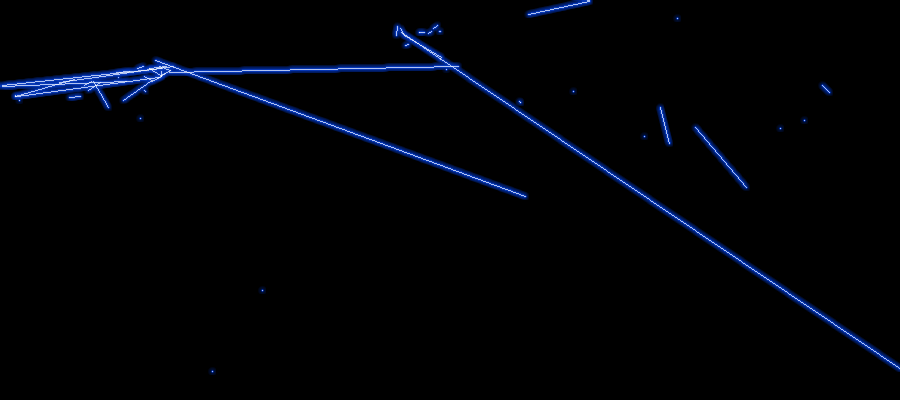

In [8]:
paths = neurohack_data[neurohack_data.hour==9]
paths = paths.iloc[:60,:]

# generate empty pixel array, choose your resolution
image_data = np.zeros((400,900))

# generate pixel coordinates of starting points and end points
xys = [row_to_pixel(row, image_data.shape) for i, row in paths.iterrows()]

# draw the lines
image_data = add_lines(image_data, xys, weights=None, width = 1)
Image.fromarray(to_image(image_data*10)[:,:,:3],mode="RGB")

In [9]:
# make a list of locations (latitude longitude) for each station id
locations = neurohack_data.groupby("Start Station ID").mean()
locations = locations.loc[:,["Start Station Latitude", "Start Station Longitude"]]

# group by each unique pair of (start-station, end-station) and count the number of trips
neurohack_data["path_id"] = [(id1,id2) for id1,id2 in zip(neurohack_data["Start Station ID"], 
                                                     neurohack_data["End Station ID"])]
paths = neurohack_data[neurohack_data["hour"]==9].groupby("path_id").count().iloc[:,[1]] 
paths.columns = ["Trip Count"]

# select only paths with more than X trips
paths = paths[paths["Trip Count"]==1]
paths["Start Station ID"] = paths.index.map(lambda x:x[0])
paths["End Station ID"] = paths.index.map(lambda x:x[1])
paths = paths[paths["Start Station ID"]!=paths["End Station ID"]]

# join latitude/longitude into new table
paths = paths.join(locations,on="Start Station ID")
locations.columns = ["End Station Latitude","End Station Longitude"]
paths = paths.join(locations,on="End Station ID")
paths.index = range(len(paths))

paths.shape

(54, 7)

In [10]:
def get_image_data(paths, min_count=0, max_count=None):
    # generate empty pixel array
    image_data = np.zeros((400*2,900*2))
    
    # generate pixel coordinates of starting points and end points
    if max_count is None:
        max_count = paths["Trip Count"].max()+1
    selector = (paths["Trip Count"]>= min_count) & (paths["Trip Count"]< max_count)
    xys = [row_to_pixel(row, image_data.shape) for i, row in paths[selector].iterrows()]

    # draw the lines
    image_data = add_lines(image_data, xys, weights=paths["Trip Count"], width = 1)
    return image_data


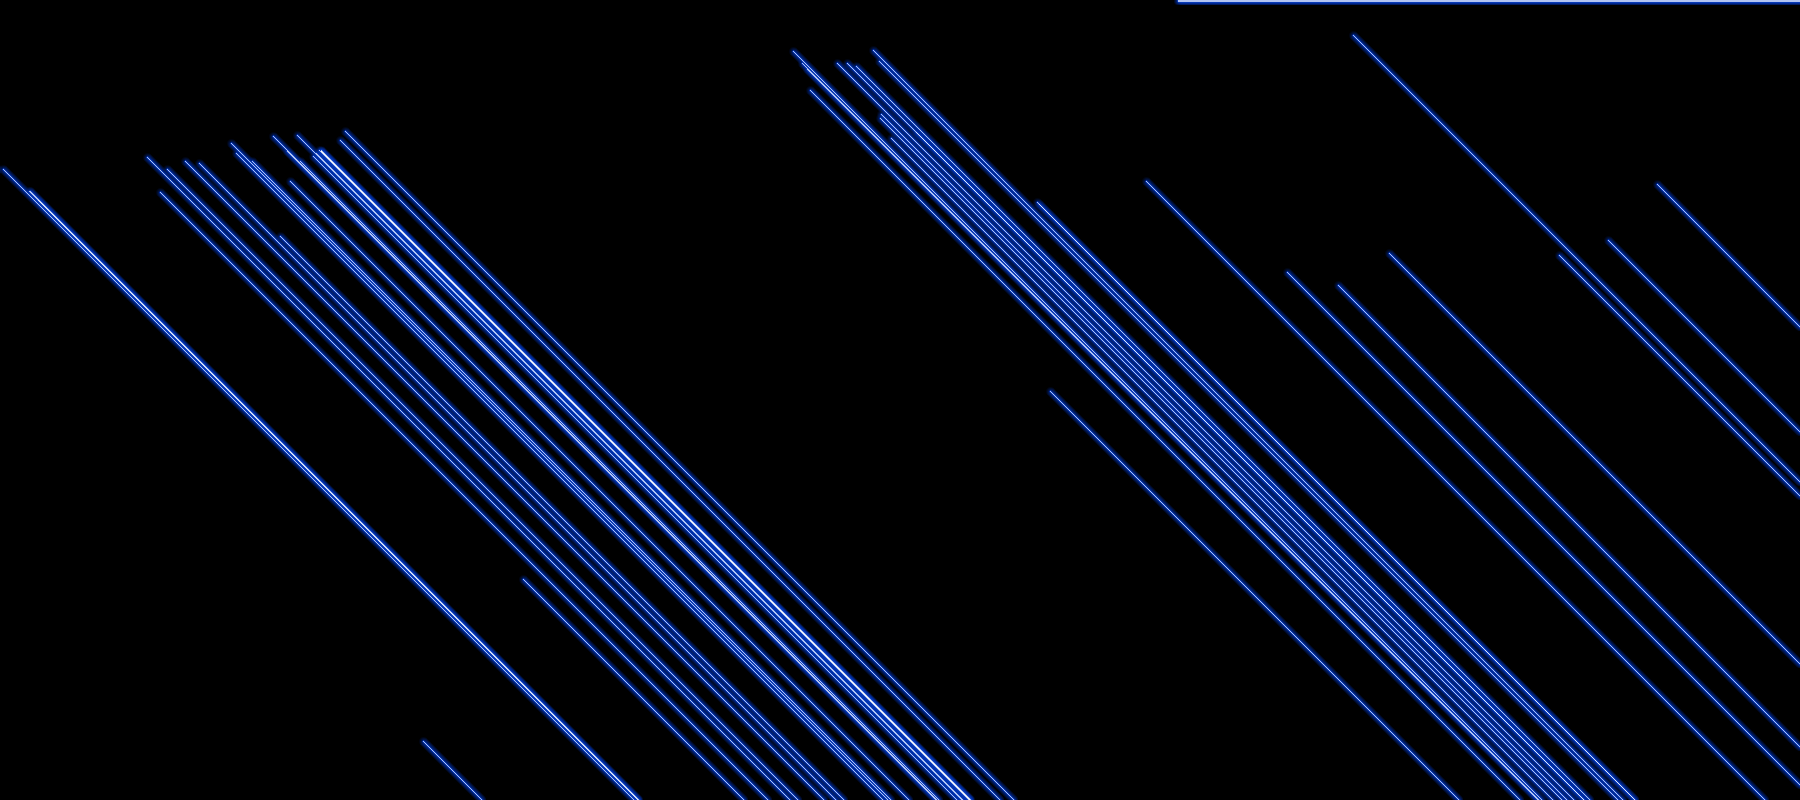

In [11]:
Image.fromarray(to_image(get_image_data(paths)*10)[:,:,:3],mode="RGB")

In [12]:
def add_alpha(image_data):
    """
    Uses the Value in HSV as an alpha channel. 
    This creates an image that blends nicely with a black background.
    """
    
    # get hsv image
    hsv = rgb_to_hsv(image_data[:,:,:3].astype(float)/255)
    
    # create new image and set alpha channel
    new_image_data = np.zeros(image_data.shape)
    new_image_data[:,:,3] = hsv[:,:,2]
    
    # set value of hsv image to either 0 or 1.
    hsv[:,:,2] = np.where(hsv[:,:,2]>0, 1, 0)
    
    # combine alpha and new rgb
    new_image_data[:,:,:3] = hsv_to_rgb(hsv)
    return new_image_data

In [13]:
# create the map
folium_map = folium.Map(location=[30.738, -10.98],
                        zoom_start=2,
                        tiles="CartoDB dark_matter",
                        width='100%')


# create the overlay
map_overlay = add_alpha(to_image(image_data*10))

# compute extent of image in lat/lon
aspect_ratio = map_overlay.shape[1]/map_overlay.shape[0]
delta_lat = (max_lon-min_lon)/aspect_ratio*np.cos(min_lat/360*2*np.pi)

# add the image to the map
img = folium.raster_layers.ImageOverlay(map_overlay,
                           bounds = [(max_lat-delta_lat,min_lon),(max_lat,max_lon)],
                           opacity = 1,
                           name = "Paths")

img.add_to(folium_map)
folium.LayerControl().add_to(folium_map)

# show the map
folium_map

In [14]:
#Next: 
#Visualize data for undergraduate to bost-bacc(lab manager, research assistant) movement
#Add to a world map

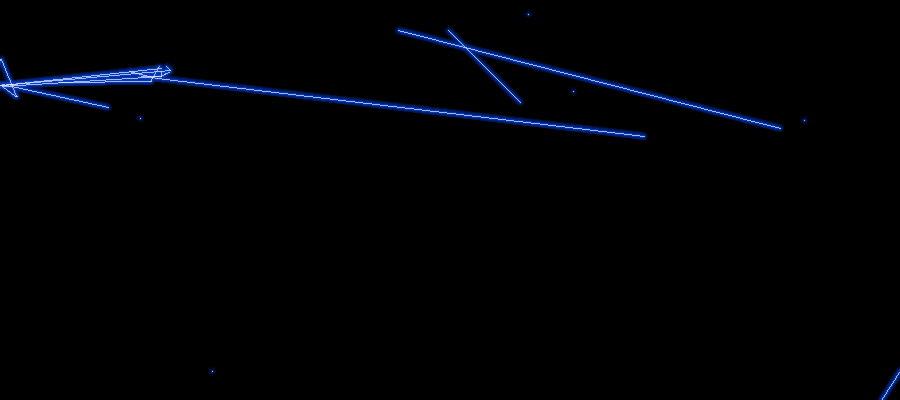

In [15]:
paths = neurohack_data[neurohack_data.hour==10]
paths = paths.iloc[:60,:]

# generate empty pixel array, choose your resolution
image_data = np.zeros((400,900))

# generate pixel coordinates of starting points and end points
xys = [row_to_pixel(row, image_data.shape) for i, row in paths.iterrows()]

# draw the lines
image_data = add_lines(image_data, xys, weights=None, width = 1)
Image.fromarray(to_image(image_data*10)[:,:,:3],mode="RGB")

In [16]:
# make a list of locations (latitude longitude) for each station id
locations = neurohack_data.groupby("Start Station ID").mean()
locations = locations.loc[:,["Start Station Latitude", "Start Station Longitude"]]

# group by each unique pair of (start-station, end-station) and count the number of trips
neurohack_data["path_id"] = [(id1,id2) for id1,id2 in zip(neurohack_data["Start Station ID"], 
                                                     neurohack_data["End Station ID"])]
paths = neurohack_data[neurohack_data["hour"]==9].groupby("path_id").count().iloc[:,[1]] 
paths.columns = ["Trip Count"]

# select only paths with more than X trips
paths = paths[paths["Trip Count"]==1]
paths["Start Station ID"] = paths.index.map(lambda x:x[0])
paths["End Station ID"] = paths.index.map(lambda x:x[1])
paths = paths[paths["Start Station ID"]!=paths["End Station ID"]]

# join latitude/longitude into new table
paths = paths.join(locations,on="Start Station ID")
locations.columns = ["End Station Latitude","End Station Longitude"]
paths = paths.join(locations,on="End Station ID")
paths.index = range(len(paths))

paths.shape

(54, 7)

In [17]:
def get_image_data(paths, min_count=0, max_count=None):
    # generate empty pixel array
    image_data = np.zeros((400*2,900*2))
    
    # generate pixel coordinates of starting points and end points
    if max_count is None:
        max_count = paths["Trip Count"].max()+1
    selector = (paths["Trip Count"]>= min_count) & (paths["Trip Count"]< max_count)
    xys = [row_to_pixel(row, image_data.shape) for i, row in paths[selector].iterrows()]

    # draw the lines
    image_data = add_lines(image_data, xys, weights=paths["Trip Count"], width = 1)
    return image_data


In [18]:
def add_alpha(image_data):
    """
    Uses the Value in HSV as an alpha channel. 
    This creates an image that blends nicely with a black background.
    """
    
    # get hsv image
    hsv = rgb_to_hsv(image_data[:,:,:3].astype(float)/255)
    
    # create new image and set alpha channel
    new_image_data = np.zeros(image_data.shape)
    new_image_data[:,:,3] = hsv[:,:,2]
    
    # set value of hsv image to either 0 or 1.
    hsv[:,:,2] = np.where(hsv[:,:,2]>0, 1, 0)
    
    # combine alpha and new rgb
    new_image_data[:,:,:3] = hsv_to_rgb(hsv)
    return new_image_data

In [19]:
# create the map
folium_map = folium.Map(location=[30.738, -10.98],
                        zoom_start=2,
                        tiles="CartoDB dark_matter",
                        width='100%')


# create the overlay
map_overlay = add_alpha(to_image(image_data*10))

# compute extent of image in lat/lon
aspect_ratio = map_overlay.shape[1]/map_overlay.shape[0]
delta_lat = (max_lon-min_lon)/aspect_ratio*np.cos(min_lat/360*2*np.pi)

# add the image to the map
img = folium.raster_layers.ImageOverlay(map_overlay,
                           bounds = [(max_lat-delta_lat,min_lon),(max_lat,max_lon)],
                           opacity = 1,
                           name = "Paths")

img.add_to(folium_map)
folium.LayerControl().add_to(folium_map)

# show the map
folium_map

In [20]:
#Next: 
#Visualize data for post-bacc to PhD movement
#Add to a world map

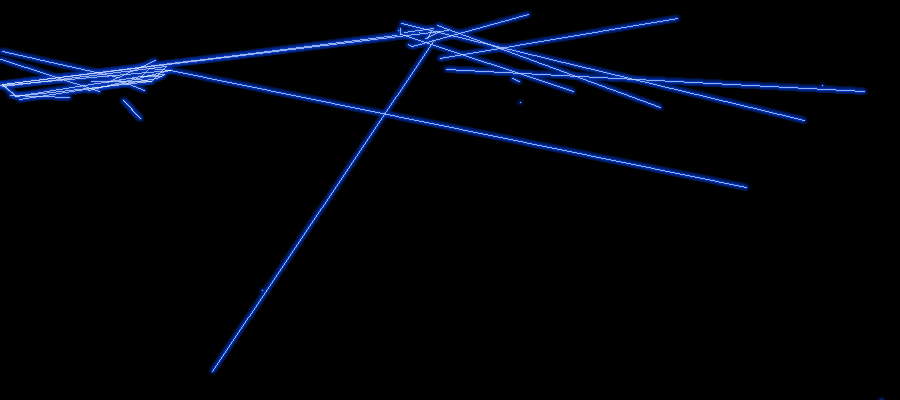

In [21]:
paths = neurohack_data[neurohack_data.hour==11]
paths = paths.iloc[:60,:]

# generate empty pixel array, choose your resolution
image_data = np.zeros((400,900))

# generate pixel coordinates of starting points and end points
xys = [row_to_pixel(row, image_data.shape) for i, row in paths.iterrows()]

# draw the lines
image_data = add_lines(image_data, xys, weights=None, width = 1)
Image.fromarray(to_image(image_data*10)[:,:,:3],mode="RGB")

In [22]:
# make a list of locations (latitude longitude) for each station id
locations = neurohack_data.groupby("Start Station ID").mean()
locations = locations.loc[:,["Start Station Latitude", "Start Station Longitude"]]

# group by each unique pair of (start-station, end-station) and count the number of trips
neurohack_data["path_id"] = [(id1,id2) for id1,id2 in zip(neurohack_data["Start Station ID"], 
                                                     neurohack_data["End Station ID"])]
paths = neurohack_data[neurohack_data["hour"]==9].groupby("path_id").count().iloc[:,[1]] 
paths.columns = ["Trip Count"]

# select only paths with more than X trips
paths = paths[paths["Trip Count"]==1]
paths["Start Station ID"] = paths.index.map(lambda x:x[0])
paths["End Station ID"] = paths.index.map(lambda x:x[1])
paths = paths[paths["Start Station ID"]!=paths["End Station ID"]]

# join latitude/longitude into new table
paths = paths.join(locations,on="Start Station ID")
locations.columns = ["End Station Latitude","End Station Longitude"]
paths = paths.join(locations,on="End Station ID")
paths.index = range(len(paths))

paths.shape

(54, 7)

In [23]:
def get_image_data(paths, min_count=0, max_count=None):
    # generate empty pixel array
    image_data = np.zeros((400*2,900*2))
    
    # generate pixel coordinates of starting points and end points
    if max_count is None:
        max_count = paths["Trip Count"].max()+1
    selector = (paths["Trip Count"]>= min_count) & (paths["Trip Count"]< max_count)
    xys = [row_to_pixel(row, image_data.shape) for i, row in paths[selector].iterrows()]

    # draw the lines
    image_data = add_lines(image_data, xys, weights=paths["Trip Count"], width = 1)
    return image_data


In [24]:
def add_alpha(image_data):
    """
    Uses the Value in HSV as an alpha channel. 
    This creates an image that blends nicely with a black background.
    """
    
    # get hsv image
    hsv = rgb_to_hsv(image_data[:,:,:3].astype(float)/255)
    
    # create new image and set alpha channel
    new_image_data = np.zeros(image_data.shape)
    new_image_data[:,:,3] = hsv[:,:,2]
    
    # set value of hsv image to either 0 or 1.
    hsv[:,:,2] = np.where(hsv[:,:,2]>0, 1, 0)
    
    # combine alpha and new rgb
    new_image_data[:,:,:3] = hsv_to_rgb(hsv)
    return new_image_data

In [25]:
# create the map
folium_map = folium.Map(location=[30.738, -10.98],
                        zoom_start=2,
                        tiles="CartoDB dark_matter",
                        width='100%')


# create the overlay
map_overlay = add_alpha(to_image(image_data*10))

# compute extent of image in lat/lon
aspect_ratio = map_overlay.shape[1]/map_overlay.shape[0]
delta_lat = (max_lon-min_lon)/aspect_ratio*np.cos(min_lat/360*2*np.pi)

# add the image to the map
img = folium.raster_layers.ImageOverlay(map_overlay,
                           bounds = [(max_lat-delta_lat,min_lon),(max_lat,max_lon)],
                           opacity = 1,
                           name = "Paths")

img.add_to(folium_map)
folium.LayerControl().add_to(folium_map)

# show the map
folium_map